# Deep Kernel Learning

In this notebook we demonstrate how GPJax can be used in conjunction with [Haiku](https://github.com/deepmind/dm-haiku) to build deep kernel Gaussian processes. Modelling data with discontinuities is a challenging task for regular Gaussian process models. However, as shown in <strong data-cite="wilson2016deep"></strong>, transforming the inputs to our Gaussian process model's kernel through a neural network can offer a solution to this.

In [1]:
import typing as tp

import haiku as hk
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax as ox
from jax.config import config
from scipy.signal import sawtooth
from jaxtyping import Float, Array
from typing import Dict
from jaxutils import Dataset
import jaxkern as jk


import gpjax as gpx
from jaxkern.kernels import (
    DenseKernelComputation,
    AbstractKernelComputation,
    AbstractKernel,
)

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)

## Dataset

As previously mentioned, deep kernels are particularly useful when the data has discontinuities. To highlight this, we will use a sawtooth function as our data.

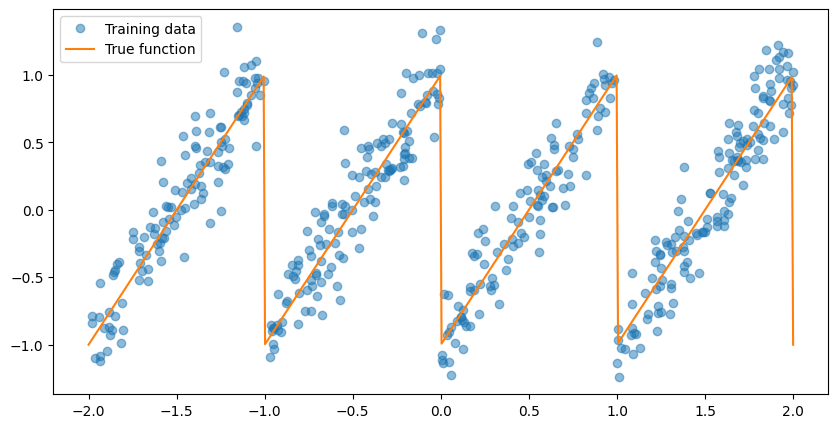

In [2]:
n = 500
noise = 0.2

x = jr.uniform(key=key, minval=-2.0, maxval=2.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.asarray(sawtooth(2 * jnp.pi * x))
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise

D = Dataset(X=x, y=y)

xtest = jnp.linspace(-2.0, 2.0, 500).reshape(-1, 1)
ytest = f(xtest)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, y, "o", label="Training data", alpha=0.5)
ax.plot(xtest, ytest, label="True function")
ax.legend(loc="best")

## Deep kernels

### Details

Instead of applying a kernel $k(\cdot, \cdot')$ directly on some data, we seek to apply a _feature map_ $\phi(\cdot)$ that projects the data to learn more meaningful representations beforehand. In deep kernel learning, $\phi$ is a neural network whose parameters are learned jointly with the GP model's hyperparameters. The corresponding kernel is then computed by $k(\phi(\cdot), \phi(\cdot'))$. Here $k(\cdot,\cdot')$ is referred to as the _base kernel_.

### Implementation

Although deep kernels are not currently supported natively in GPJax, defining one is straightforward as we now demonstrate. Using the base `AbstractKernel` object given in GPJax, we provide a mixin class named `_DeepKernelFunction` to facilitate the user supplying the neural network and base kernel of their choice. Kernel matrices are then computed using the regular `gram` and `cross_covariance` functions.

In [3]:
class DeepKernelFunction(AbstractKernel):
    def __init__(
        self,
        network: hk.Module,
        base_kernel: AbstractKernel,
        compute_engine: AbstractKernelComputation = DenseKernelComputation,
        active_dims: tp.Optional[tp.List[int]] = None,
    ) -> None:
        super().__init__(compute_engine, active_dims, True, False, "Deep    Kernel")
        self.network = network
        self.base_kernel = base_kernel

    def __call__(
        self,
        params: Dict,
        x: Float[Array, "1 D"],
        y: Float[Array, "1 D"],
    ) -> Float[Array, "1"]:
        xt = self.network.apply(params=params, x=x)
        yt = self.network.apply(params=params, x=y)
        return self.base_kernel(params, xt, yt)

    def initialise(self, dummy_x: Float[Array, "1 D"], key: jr.KeyArray) -> None:
        nn_params = self.network.init(rng=key, x=dummy_x)
        base_kernel_params = self.base_kernel.init_params(key)
        self._params = {**nn_params, **base_kernel_params}

    def init_params(self, key: jr.KeyArray) -> Dict:
        return self._params

    # This is depreciated. Can be removed once JaxKern is updated.
    def _initialise_params(self, key: jr.KeyArray) -> Dict:
        return self.init_params(key)

### Defining a network

With a deep kernel object created, we proceed to define a neural network. Here we consider a small multi-layer perceptron with two linear hidden layers and ReLU activation functions between the layers. The first hidden layer contains 32 units, while the second layer contains 64 units. Finally, we'll make the output of our network a single unit. However, it would be possible to project our data into a $d-$dimensional space for $d>1$. In these instances, making the [base kernel ARD](https://gpjax.readthedocs.io/en/latest/nbs/kernels.html#Active-dimensions) would be sensible.
Users may wish to design more intricate network structures for more complex tasks, which functionality is supported well in Haiku.

In [4]:
def forward(x):
    mlp = hk.Sequential(
        [
            hk.Linear(32),
            jax.nn.relu,
            hk.Linear(64),
            jax.nn.relu,
            hk.Linear(1),
        ]
    )
    return mlp(x)


forward_linear1 = hk.transform(forward)
forward_linear1 = hk.without_apply_rng(forward_linear1)

## Defining a model

Having characterised the feature extraction network, we move to define a Gaussian process parameterised by this deep kernel. We consider a third-order Matérn base kernel and assume a Gaussian likelihood. Parameters, trainability status and transformations are initialised in the usual manner.

In [5]:
base_kernel = jk.RBF()
kernel = DeepKernelFunction(network=forward_linear1, base_kernel=base_kernel)
kernel.initialise(x, key)
prior = gpx.Prior(kernel=kernel)
likelihood = gpx.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

### Optimisation

We train our model via maximum likelihood estimation of the marginal log-likelihood. The parameters of our neural network are learned jointly with the model's hyperparameter set.

With the inclusion of a neural network, we take this opportunity to highlight the additional benefits gleaned from using [Optax](https://optax.readthedocs.io/en/latest/) for optimisation. In particular, we showcase the ability to use a learning rate scheduler that decays the optimiser's learning rate throughout the inference. We decrease the learning rate according to a half-cosine curve over 1000 iterations, providing us with large step sizes early in the optimisation procedure before approaching more conservative values, ensuring we do not step too far. We also consider a linear warmup, where the learning rate is increased from 0 to 1 over 50 steps to get a reasonable initial learning rate value.

In [6]:
parameter_state = gpx.initialise(posterior, key)

negative_mll = jax.jit(posterior.marginal_log_likelihood(D, negative=True))

/Users/tompinder/miniforge3/envs/gpjax/lib/python3.9/site-packages/gpjax/parameters.py:194: UserWarning: Parameter w has no transform. Defaulting to identity transfom.
  warnings.warn(
/Users/tompinder/miniforge3/envs/gpjax/lib/python3.9/site-packages/gpjax/parameters.py:194: UserWarning: Parameter b has no transform. Defaulting to identity transfom.
  warnings.warn(


In [7]:
parameter_state = gpx.initialise(posterior, key)

negative_mll = jax.jit(posterior.marginal_log_likelihood(D, negative=True))
negative_mll(parameter_state.params)

schedule = ox.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=0.01,
    warmup_steps=50,
    decay_steps=1_000,
    end_value=0.0,
)

optimiser = ox.chain(
    ox.clip(1.0),
    ox.adamw(learning_rate=schedule),
)

inference_state = gpx.fit(
    objective=negative_mll,
    parameter_state=parameter_state,
    optax_optim=optimiser,
    num_iters=2500,
)

learned_params, training_history = inference_state.unpack()

  0%|          | 0/2500 [00:00<?, ?it/s]

## Prediction

With a set of learned parameters, the only remaining task is to predict the output of the model. We can do this by simply applying the model to a test data set.

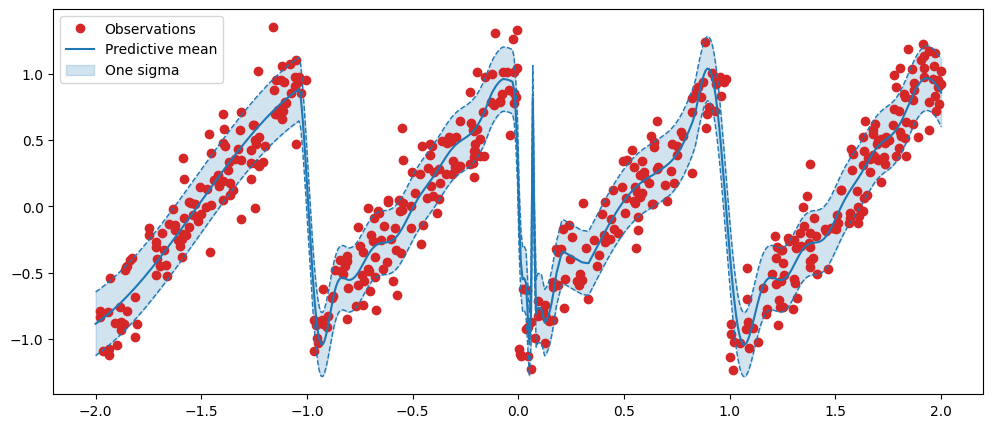

In [8]:
latent_dist = posterior(learned_params, D)(xtest)
predictive_dist = likelihood(learned_params, latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", label="Observations", color="tab:red")
ax.plot(xtest, predictive_mean, label="Predictive mean", color="tab:blue")
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - predictive_std,
    predictive_mean + predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="One sigma",
)
ax.plot(
    xtest,
    predictive_mean - predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)
ax.plot(
    xtest,
    predictive_mean + predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)
ax.legend()

## System configuration

In [9]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Thomas Pinder (edited by Daniel Dodd)'

Author: Thomas Pinder (edited by Daniel Dodd)

Last updated: Sat Jan 14 2023

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.8.0

optax     : 0.1.4
gpjax     : 0.5.8
jax       : 0.4.1
matplotlib: 3.3.3
haiku     : 0.0.9
jaxkern   : 0.0.4

Watermark: 2.3.1

